# Instructions

#### In this bonus lab business case study, you will be using the Sakila database of movie rentals. Choose one of the cases below, or both if you dare:

We will be trying to predict if a film will be rented this month based on their previous activity and other details. We will first construct a table with:

Film ID

Category

Total number of copies

*Bonus - How many "stars" actrs. in the film *

How many times the film was rented last month (MAY/2005)

If the film was rented this month (JUNE/2005)

Once you extract that information, and any other that seems fit, predict which films will be rented this month.

### Must be done at March 11th

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import getpass  # to get the password without showing the input
password = getpass.getpass()

connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

········


The first query retrieves the number of copies of each film

In [2]:
query1 = '''create or replace view copies_per_film as
select film_id, count(inventory_id) as number_of_copies from inventory
group by film_id;'''
query2 = '''select * from copies_per_film;'''

In [3]:
view1 = pd.read_sql_query(query2, engine)
view1

,film_id,number_of_copies
0,1,8
1,2,3
2,3,4
3,4,7
4,5,3
...,...,...
953,996,2
954,997,2
955,998,2
956,999,5


The second query retrieves the number of movies in which each actor played

In [4]:
query3 = '''create or replace view count_per_actor as
select film_id, actor_id, count(film_id) as films_count from film_actor
group by actor_id;'''
query4 = '''select * from count_per_actor;'''

In [5]:
view2 = pd.read_sql_query(query4, engine)
view2

,film_id,actor_id,films_count
0,1,1,19
1,3,2,25
2,17,3,22
3,23,4,22
4,19,5,29
...,...,...,...
195,64,196,30
196,6,197,33
197,1,198,40
198,67,199,15


Here we retrieve how many times each movie was rented in may:

In [6]:
query5 = '''CREATE OR REPLACE VIEW rental_may AS
SELECT f.film_id, count(r.rental_id) as nb_rentals_may
FROM film f
JOIN inventory i ON f.film_id = i.film_id
JOIN rental r ON i.inventory_id = r.inventory_id
WHERE rental_date LIKE '2005-05%'
GROUP BY f.film_id;'''
query6 = '''select * from rental_may;'''

In [7]:
view3 = pd.read_sql_query(query6, engine)
view3

,film_id,nb_rentals_may
0,80,1
1,333,2
2,373,2
3,535,4
4,450,5
...,...,...
681,864,1
682,859,1
683,689,1
684,47,1


This query retrieves the main dataframe:

In [8]:
big_query = '''
SELECT extract(YEAR_MONTH FROM r.rental_date) AS yearmonth, r.rental_id, r.inventory_id, cpf.number_of_copies, f.film_id, f.title, f.rating, count(f.film_id) AS film_rental_count, rm.nb_rentals_may, fa.actor_id, concat(a.first_name, ' ', a.last_name) AS main_actor, max(cpa.films_count), cat.name AS category_name
FROM rental r
LEFT JOIN inventory i ON r.inventory_id = i.inventory_id
JOIN rental_may rm ON i.film_id = rm.film_id
JOIN film f ON i.film_id = f.film_id
JOIN film_category fc ON f.film_id = fc.film_id
JOIN film_actor fa ON f.film_id = fa.film_id
JOIN actor a ON fa.actor_id = a.actor_id
JOIN category cat ON fc.category_id = cat.category_id
JOIN count_per_actor cpa ON a.actor_id = cpa.actor_id
JOIN copies_per_film cpf ON f.film_id = cpf.film_id 
WHERE extract(YEAR_MONTH FROM r.rental_date) < 200507
GROUP BY f.film_id
ORDER BY f.film_id
;'''

In [9]:
df = pd.read_sql_query(big_query, engine)
df

,yearmonth,rental_id,inventory_id,number_of_copies,film_id,title,rating,film_rental_count,nb_rentals_may,actor_id,main_actor,max(cpa.films_count),category_name
0,200505,972,2,8,1,ACADEMY DINOSAUR,PG,50,2,1,PENELOPE GUINESS,40,Documentary
1,200505,1033,14,4,3,ADAPTATION HOLES,NC-17,10,1,2,NICK WAHLBERG,32,Documentary
2,200505,995,17,7,4,AFFAIR PREJUDICE,G,20,2,41,JODIE DEGENERES,36,Horror
3,200505,552,23,3,5,AFRICAN EGG,G,15,1,51,GARY PHOENIX,39,Family
4,200505,317,26,6,6,AGENT TRUMAN,PG,35,2,21,KIRSTEN PALTROW,37,Foreign
...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,200505,813,4554,3,994,WYOMING STORM,PG-13,24,2,6,BETTE NICHOLSON,34,New
680,200505,677,4558,6,995,YENTL IDAHO,R,5,2,197,REESE WEST,33,Horror
681,200506,1884,4567,2,998,ZHIVAGO CORE,NC-17,18,1,13,UMA WOOD,35,Horror
682,200506,2801,4572,5,999,ZOOLANDER FICTION,R,15,1,52,CARMEN HUNT,32,Children


In [10]:
df.shape, df.dtypes

((684, 13),
 yearmonth                int64
 rental_id                int64
 inventory_id             int64
 number_of_copies         int64
 film_id                  int64
 title                   object
 rating                  object
 film_rental_count        int64
 nb_rentals_may           int64
 actor_id                 int64
 main_actor              object
 max(cpa.films_count)     int64
 category_name           object
 dtype: object)

In [11]:
df = df.set_index('title')
df

,yearmonth,rental_id,inventory_id,number_of_copies,film_id,rating,film_rental_count,nb_rentals_may,actor_id,main_actor,max(cpa.films_count),category_name
title,,,,,,,,,,,,
ACADEMY DINOSAUR,200505,972,2,8,1,PG,50,2,1,PENELOPE GUINESS,40,Documentary
ADAPTATION HOLES,200505,1033,14,4,3,NC-17,10,1,2,NICK WAHLBERG,32,Documentary
AFFAIR PREJUDICE,200505,995,17,7,4,G,20,2,41,JODIE DEGENERES,36,Horror
AFRICAN EGG,200505,552,23,3,5,G,15,1,51,GARY PHOENIX,39,Family
AGENT TRUMAN,200505,317,26,6,6,PG,35,2,21,KIRSTEN PALTROW,37,Foreign
...,...,...,...,...,...,...,...,...,...,...,...,...
WYOMING STORM,200505,813,4554,3,994,PG-13,24,2,6,BETTE NICHOLSON,34,New
YENTL IDAHO,200505,677,4558,6,995,R,5,2,197,REESE WEST,33,Horror
ZHIVAGO CORE,200506,1884,4567,2,998,NC-17,18,1,13,UMA WOOD,35,Horror


In [12]:
df['yearmonth'].unique()

array([200505, 200506], dtype=int64)

In [13]:
# ids are just labels, they are of no use for DA 
df1 = df.drop(columns=['rental_id', 'inventory_id', 'film_id', 'actor_id', 'main_actor'])
df1

,yearmonth,number_of_copies,rating,film_rental_count,nb_rentals_may,max(cpa.films_count),category_name
title,,,,,,,
ACADEMY DINOSAUR,200505,8,PG,50,2,40,Documentary
ADAPTATION HOLES,200505,4,NC-17,10,1,32,Documentary
AFFAIR PREJUDICE,200505,7,G,20,2,36,Horror
AFRICAN EGG,200505,3,G,15,1,39,Family
AGENT TRUMAN,200505,6,PG,35,2,37,Foreign
...,...,...,...,...,...,...,...
WYOMING STORM,200505,3,PG-13,24,2,34,New
YENTL IDAHO,200505,6,R,5,2,33,Horror
ZHIVAGO CORE,200506,2,NC-17,18,1,35,Horror


In [14]:
df1 = df1.rename(columns={'max(cpa.films_count)': 'film_count_main_actor'})
df1

,yearmonth,number_of_copies,rating,film_rental_count,nb_rentals_may,film_count_main_actor,category_name
title,,,,,,,
ACADEMY DINOSAUR,200505,8,PG,50,2,40,Documentary
ADAPTATION HOLES,200505,4,NC-17,10,1,32,Documentary
AFFAIR PREJUDICE,200505,7,G,20,2,36,Horror
AFRICAN EGG,200505,3,G,15,1,39,Family
AGENT TRUMAN,200505,6,PG,35,2,37,Foreign
...,...,...,...,...,...,...,...
WYOMING STORM,200505,3,PG-13,24,2,34,New
YENTL IDAHO,200505,6,R,5,2,33,Horror
ZHIVAGO CORE,200506,2,NC-17,18,1,35,Horror


Here we check if the movie was reted in june, so we create an extra column with a binary information:

In [15]:
def determine_rental(x):
    if x == 200506:
        return 1
    else:
        return 0
df1['rented_june'] = df1['yearmonth'].apply(determine_rental)
df1

,yearmonth,number_of_copies,rating,film_rental_count,nb_rentals_may,film_count_main_actor,category_name,rented_june
title,,,,,,,,
ACADEMY DINOSAUR,200505,8,PG,50,2,40,Documentary,0
ADAPTATION HOLES,200505,4,NC-17,10,1,32,Documentary,0
AFFAIR PREJUDICE,200505,7,G,20,2,36,Horror,0
AFRICAN EGG,200505,3,G,15,1,39,Family,0
AGENT TRUMAN,200505,6,PG,35,2,37,Foreign,0
...,...,...,...,...,...,...,...,...
WYOMING STORM,200505,3,PG-13,24,2,34,New,0
YENTL IDAHO,200505,6,R,5,2,33,Horror,0
ZHIVAGO CORE,200506,2,NC-17,18,1,35,Horror,1


In [16]:
#df1['rented_june'] = df1['rented_june'].astype('object') 

In [17]:
df2 = df1.copy()

In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 684 entries, ACADEMY DINOSAUR to ZORRO ARK
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   yearmonth              684 non-null    int64 
 1   number_of_copies       684 non-null    int64 
 2   rating                 684 non-null    object
 3   film_rental_count      684 non-null    int64 
 4   nb_rentals_may         684 non-null    int64 
 5   film_count_main_actor  684 non-null    int64 
 6   category_name          684 non-null    object
 7   rented_june            684 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 48.1+ KB


In [19]:
for col in df2.select_dtypes('object'):
    print(df2[col].value_counts(), '\n')

PG-13    155
NC-17    142
R        133
PG       129
G        125
Name: rating, dtype: int64 

Family         52
Documentary    51
Drama          50
Action         50
Animation      49
Sports         49
Foreign        46
Sci-Fi         46
Children       40
Classics       40
Games          39
Comedy         38
New            36
Music          36
Travel         32
Horror         30
Name: category_name, dtype: int64 



In [20]:
df2.describe()

,yearmonth,number_of_copies,film_rental_count,nb_rentals_may,film_count_main_actor,rented_june
count,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000
mean,200505.349415,5.080409,24.527778,1.687135,33.723684,0.349415
std,0.477134,1.747861,15.016169,0.853077,3.896685,0.477134
min,200505.000000,2.000000,2.000000,1.000000,16.000000,0.000000
25%,200505.000000,4.000000,12.000000,1.000000,32.000000,0.000000
50%,200505.000000,5.000000,21.000000,1.000000,33.000000,0.000000
75%,200506.000000,6.000000,32.000000,2.000000,35.000000,1.000000
max,200506.000000,8.000000,81.000000,5.000000,42.000000,1.000000


In [21]:
df2.isna().sum()

yearmonth                0
number_of_copies         0
rating                   0
film_rental_count        0
nb_rentals_may           0
film_count_main_actor    0
category_name            0
rented_june              0
dtype: int64

In [22]:
df2.isnull().sum()

yearmonth                0
number_of_copies         0
rating                   0
film_rental_count        0
nb_rentals_may           0
film_count_main_actor    0
category_name            0
rented_june              0
dtype: int64

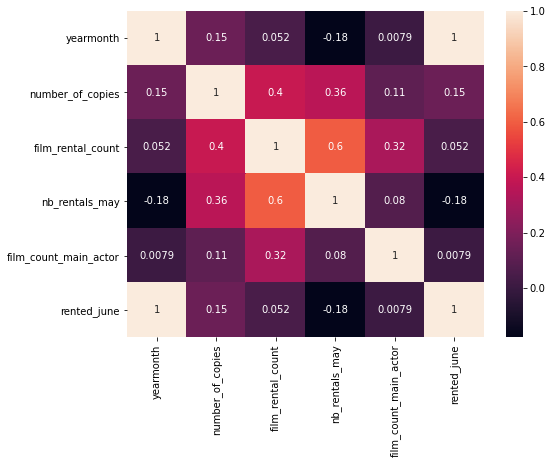

In [23]:
corr_matrix=df2.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

Since yearmonth and rented_june are -logically- entirely correlated to each other, we drop yearmonth:

In [24]:
df2 = df2.drop('yearmonth', axis = 1)
df2

,number_of_copies,rating,film_rental_count,nb_rentals_may,film_count_main_actor,category_name,rented_june
title,,,,,,,
ACADEMY DINOSAUR,8,PG,50,2,40,Documentary,0
ADAPTATION HOLES,4,NC-17,10,1,32,Documentary,0
AFFAIR PREJUDICE,7,G,20,2,36,Horror,0
AFRICAN EGG,3,G,15,1,39,Family,0
AGENT TRUMAN,6,PG,35,2,37,Foreign,0
...,...,...,...,...,...,...,...
WYOMING STORM,3,PG-13,24,2,34,New,0
YENTL IDAHO,6,R,5,2,33,Horror,0
ZHIVAGO CORE,2,NC-17,18,1,35,Horror,1


C:\Users\Johal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


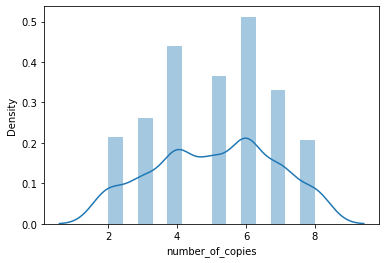

C:\Users\Johal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


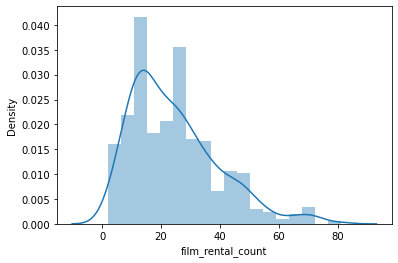

C:\Users\Johal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


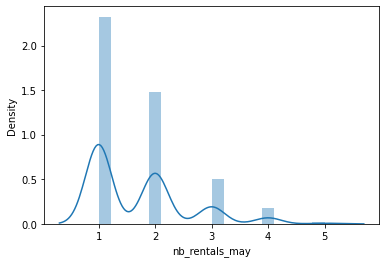

C:\Users\Johal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


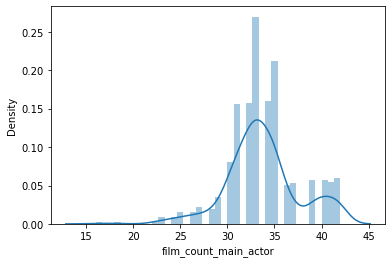

C:\Users\Johal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


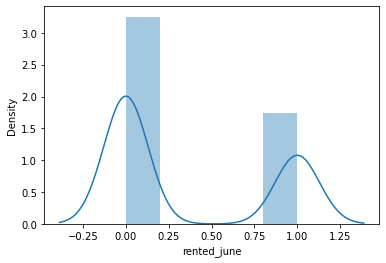

In [25]:
for col in df2.select_dtypes(np.number):
    sns.distplot(df2[col])
    plt.show()

In [26]:
# There's some data imbalance

In [27]:
# some numerical data here doesn't make sense (ids)

In [28]:
df2.dtypes

number_of_copies          int64
rating                   object
film_rental_count         int64
nb_rentals_may            int64
film_count_main_actor     int64
category_name            object
rented_june               int64
dtype: object

In [29]:
y = df2['rented_june']

In [30]:
X = df2.drop('rented_june', axis = 1)

In [31]:
X = pd.get_dummies(X)
X

,number_of_copies,film_rental_count,nb_rentals_may,film_count_main_actor,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_name_Action,...,category_name_Drama,category_name_Family,category_name_Foreign,category_name_Games,category_name_Horror,category_name_Music,category_name_New,category_name_Sci-Fi,category_name_Sports,category_name_Travel
title,,,,,,,,,,,,,,,,,,,,,
ACADEMY DINOSAUR,8,50,2,40,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ADAPTATION HOLES,4,10,1,32,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AFFAIR PREJUDICE,7,20,2,36,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
AFRICAN EGG,3,15,1,39,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
AGENT TRUMAN,6,35,2,37,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WYOMING STORM,3,24,2,34,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
YENTL IDAHO,6,5,2,33,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
ZHIVAGO CORE,2,18,1,35,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
classification = LogisticRegression(random_state=42, max_iter = 1000)

classification.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [34]:
classification.score(X_test, y_test)

0.6861313868613139

In [35]:
predictions = classification.predict(X_test)
from sklearn import metrics
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       105
           1       0.30      0.25      0.27        32

    accuracy                           0.69       137
   macro avg       0.54      0.53      0.54       137
weighted avg       0.67      0.69      0.68       137



In [36]:
confusion_matrix(y_test, predictions)

array([[86, 19],
       [24,  8]], dtype=int64)

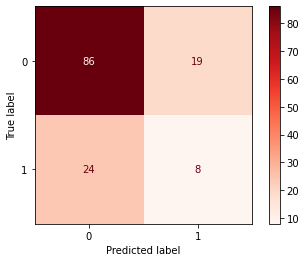

In [37]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(classification, X_test, y_test, cmap='Reds')
plt.show()

In [38]:
df2['rating'].dtypes

dtype('O')

In [39]:
y = df2['rented_june']
X = df2.drop('rented_june', axis = 1)

In [40]:
X = pd.get_dummies(X)
X

,number_of_copies,film_rental_count,nb_rentals_may,film_count_main_actor,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_name_Action,...,category_name_Drama,category_name_Family,category_name_Foreign,category_name_Games,category_name_Horror,category_name_Music,category_name_New,category_name_Sci-Fi,category_name_Sports,category_name_Travel
title,,,,,,,,,,,,,,,,,,,,,
ACADEMY DINOSAUR,8,50,2,40,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ADAPTATION HOLES,4,10,1,32,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AFFAIR PREJUDICE,7,20,2,36,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
AFRICAN EGG,3,15,1,39,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
AGENT TRUMAN,6,35,2,37,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WYOMING STORM,3,24,2,34,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
YENTL IDAHO,6,5,2,33,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
ZHIVAGO CORE,2,18,1,35,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Let's try an upsampling with smote:

In [41]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

1    445
0    445
Name: rented_june, dtype: int64

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

In [43]:
classification = LogisticRegression(random_state=42, max_iter = 1000)

classification.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [44]:
classification.score(X_test, y_test)

0.7471910112359551

In [45]:
predictions = classification.predict(X_test)
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77        97
           1       0.74      0.69      0.71        81

    accuracy                           0.75       178
   macro avg       0.75      0.74      0.74       178
weighted avg       0.75      0.75      0.75       178



Test classification score improved (0.76 vs. 0.69)

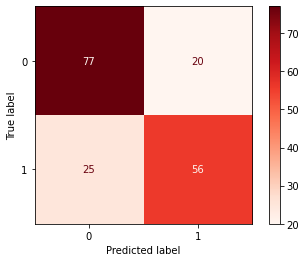

In [46]:
plot_confusion_matrix(classification, X_test, y_test, cmap='Reds')
plt.show()

Let's check by downsapling with Tomek links:

In [47]:
from imblearn.under_sampling import TomekLinks
tomek = TomekLinks()
X_tl, y_tl = tomek.fit_resample(X, y)
y_tl.value_counts()

0    369
1    239
Name: rented_june, dtype: int64

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.2, random_state=42)

In [49]:
classification = LogisticRegression(random_state=42, max_iter = 1000)

classification.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [50]:
classification.score(X_test, y_test)

0.6967213114754098

In [51]:
predictions = classification.predict(X_test)
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.73      0.85      0.78        79
           1       0.60      0.42      0.49        43

    accuracy                           0.70       122
   macro avg       0.66      0.63      0.64       122
weighted avg       0.68      0.70      0.68       122



This result is worse than the previous one

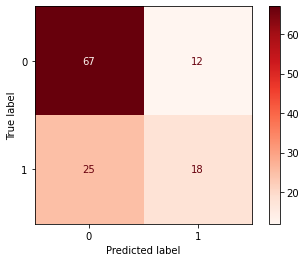

In [52]:
plot_confusion_matrix(classification, X_test, y_test, cmap='Reds')
plt.show()

With value weights:

In [53]:
y = df2['rented_june']
X = pd.get_dummies(df2.drop('rented_june', axis = 1))

total = sum(df2['rented_june'].value_counts())

weights = {'1': df2['rented_june'].value_counts()[1]/total,
           '0': df2['rented_june'].value_counts()[0]/total}

classification = LogisticRegression(random_state=42, class_weight=weights)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [56]:
classification.score(X_test, y_test)

0.6861313868613139

In [57]:
predictions = classification.predict(X_test)
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       105
           1       0.30      0.25      0.27        32

    accuracy                           0.69       137
   macro avg       0.54      0.53      0.54       137
weighted avg       0.67      0.69      0.68       137



This result is slightly worse as well